In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

## Read in Protein Structure
1. We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"
    * [More Info on working with PDB structures in DataFrames](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/)

In [2]:
data_path = Path('/home', 'eclay','Pfam-A.full')
data_path = Path('Pfam-A.full')
DCA_ER_dir = Path('/home/evan/PycharmProjects/DCA_ER/')



pfam_id = 'PF00023'
pfam_id = 'PF00011'
pfam_id = 'PF00186'

n_jobs = 6
create_new = False


if 0:
    DCA_ER_dir = '/home/eclay/DCA_ER/'
    msa_npy_file = '/home/eclay/Pfam-A.full/%s/msa.npy' % pfam_id # Hurricane Location
    msa_fa_file  = '/home/eclay/Pfam-A.full/%s/msa.fa' % pfam_id # Hurricane Location
    pdb_ref_file = '/home/eclay/Pfam-A.full/%s/pdb_refs.npy' % pfam_id # Hurricane Location
if 1:
    DCA_ER_dir = '/home/evan/PycharmProjects/DCA_ER/'
    msa_npy_file = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
    msa_fa_file  = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
    pdb_ref_file = '/home/evan/PycharmProjects/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
    out_dir = '%sprotein_data/di/' % DCA_ER_dir
if 0:
    DCA_ER_dir = '/home/ecresswell/DCA_ER/'
    msa_npy_file = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
    msa_fa_file  = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
    pdb_ref_file = '/home/ecresswell/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
    out_dir = '%sprotein_data/di/' % DCA_ER_dir



# Set DCA_ER directory
DCA_dir = os.getcwd()

# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()

# print("Direct Information from Expectation reflection:\n",di)
def no_diag(mat, diag_l, s_index=None, make_big=False):
    rows, columns = mat.shape
    if make_big:
        new_mat = 100. * np.ones((rows,columns))
    else:
        new_mat = np.zeros((rows,columns))
    for row in range(rows):
        for col in range(columns):
            if s_index is None:
                if abs(row-col) > diag_l:
                    new_mat[row, col] = mat[row ,col]
            else:
                if abs(s_index[row]-s_index[col]) > diag_l:
                    new_mat[row, col] = mat[row ,col]    
    return new_mat


number of pdb structures: 372


PDB DataFrame needs to have PF######, PDB-id, as well as start and end locations of amino acids, as well as reference sequence in msa (not in current file with all pdb data)
### PDB Website Search Engine
   * We can visualize the complex structure of the proteins
   * The data-base below gives further information on the proteins above (input pdb_id)

### Define contact map
2. Import contact map functions from newly defined tools python module

In [3]:
import ecc_tools as tools

In [4]:
ipdb = 0
printing = True
print('seq:',int(pdb[ipdb,1]))



s0,cols_removed, s_index, tpdb, orig_seq_len = data_processing(data_path, pfam_id, ipdb,\
                gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, conserved_cols=0.9, printing=printing, out_dir=processed_data_dir)
print('\n\n\nPreprocessed reference Sequence: ', s0[tpdb])

# npy2fa does not remove cols this way we are as close to original as possible
msa_outfile, ref_outfile, s0, cols_removed, s_index, tpdb, orig_seq_len  = tools.npy2fa(pfam_id, msa_npy_file, pdb_ref_file=pdb_ref_file, ipdb=ipdb, preprocess=True,gap_seqs=.2, gap_cols=.2, prob_low=.004, conserved_cols=.9, letter_format=False)
# data processing
print(s0[1934])
print(s0[3522])
print(s0.shape, '\n\n\n')

# # Load pydca trimmed datrimmed_data_outfile = '%sprotein_data/data_processing_output/MSA_%s_Trimmed.fa' % (DCA_ER_dir, pfam_id)
# trimmed_msa_file = Path(DCA_ER_dir, 'protein_data/data_processing_output/MSA_%s_Trimmed.fa' % pfam_id)
# s0_pydca = tools.read_FASTA(str(trimmed_msa_file), ref_index = int(pdb[ipdb,1]))

# Load csv of PDB-PFAM mapping.
#    downloaded from 
#    ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/pdb_pfam_mapping.csv.gz
pdb_id = pdb_df.iloc[ipdb]['pdb_id']
pdb_chain = pdb_df.iloc[ipdb]['chain']

pdb_pfam_map_file = Path('%s/protein_data/pdb_data/pdb_pfam_mapping.csv' % DCA_dir)
pdb_map_df = pd.read_csv(pdb_pfam_map_file, sep=',', header=1)
print(pdb_map_df.head())

pdb_id_map_df = pdb_map_df.loc[pdb_map_df['PDB']==pdb_id.lower()]
pdb_pfam_map = pdb_id_map_df.loc[pdb_id_map_df['CHAIN']==pdb_chain]

# print('wtf pdb length matching S sequence length ', orig_seq_len )
# for pdb_index, pdb_info in pdb_pfam_map.iterrows(): # loop trhough rows of dataframe
#     pdb_len = pdb_info['PDB_END'] - pdb_info['PDB_START']
#     print(pdb_len)
#     if pdb_len == orig_seq_len:
#         break
        
#       

seq: 69
pdb ref example (pdb[0])  (after UTF-8 decode, removing 'b'):
 ['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
tpdb (s_ipdb) is :  69
#

-------------------------Remove Gaps--------------------------#
Shape of s is :  (7750, 918)
s = 
 [['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' '-']
 ...
 ['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' '-']
 ['-' '-' '-' ... '-' '-' '-']]
s[tpdb] shape is  (160,)
s = 
 [['-' '-' '-' ... 'Y' 'E' 'K']
 ['M' 'I' 'S' ... 'W' 'E' 'R']
 ['-' 'L' 'A' ... 'Y' 'E' 'R']
 ...
 ['-' '-' '-' ... '-' '-' '-']
 ['-' 'V' 'S' ... 'Y' 'E' 'R']
 ['-' 'F' 'S' ... 'Y' 'E' 'K']]
though s still has gaps, s[69] does not:
 ['M' 'I' 'S' 'H' 'I' 'V' 'A' 'M' 'D' 'E' 'N' 'R' 'V' 'I' 'G' 'K' 'D' 'N'
 'R' 'L' 'P' 'W' 'H' 'L' 'P' 'A' 'D' 'L' 'A' 'Y' 'F' 'K' 'R' 'V' 'T' 'M'
 'G' 'H' 'A' 'I' 'V' 'M' 'G' 'R' 'K' 'T' 'F' 'E' 'A' 'I' 'G' 'R' 'P' 'L'
 'P' 'G' 'R' 'D' 'N' 'V' 'V' 'V' 'T' 'R' 'N' 'R' 'S' 'F' 'R' 'P' 

Polypeptide range for contact map:  [1, 160]


#-----------------------#
Generating Contact Map
#----------------------------#

['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
Structure exists: '/home/evan/PycharmProjects/DCA_ER/protein_data/pdb_data/pdb1zdr.ent' 
peptide build of chain produced 1 elements
original poly_seq: 
 ['M', 'I', 'S', 'H', 'I', 'V', 'A', 'M', 'D', 'E', 'N', 'R', 'V', 'I', 'G', 'K', 'D', 'N', 'R', 'L', 'P', 'W', 'H', 'L', 'P', 'A', 'D', 'L', 'A', 'Y', 'F', 'K', 'R', 'V', 'T', 'M', 'G', 'H', 'A', 'I', 'V', 'M', 'G', 'R', 'K', 'T', 'F', 'E', 'A', 'I', 'G', 'R', 'P', 'L', 'P', 'G', 'R', 'D', 'N', 'V', 'V', 'V', 'T', 'G', 'N', 'R', 'S', 'F', 'R', 'P', 'E', 'G', 'C', 'L', 'V', 'L', 'H', 'S', 'L', 'E', 'E', 'V', 'K', 'Q', 'W', 'I', 'A', 'S', 'R', 'A', 'D', 'E', 'V', 'F', 'I', 'I', 'G', 'G', 'A', 'E', 'L', 'F', 'R', 'A', 'T', 'M', 'P', 'I', 'V', 'D', 'R', 'L', 'Y', 'V', 'T', 'K', 'I', 'F', 'A', 'S', 'F', 'P', 'G', 'D', 'T', 'F', 'Y', 'P', 'P', 'I', 'S', 

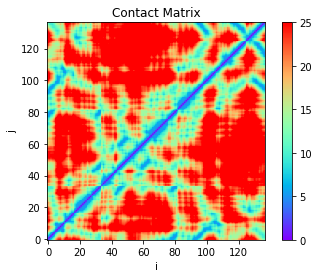

In [5]:
## Generate and Plot Contact Map from PDB coordinates!
# Check that pdb--pfam mapping is unique
if pdb_pfam_map.shape[0] > 1:
    print('Unable to get unique PDB-->Pfam mapping')
    print(pdb_pfam_map)

# pp_range = [pdb_info['PDB_START'], pdb_info['PDB_END']]
pp_range = [pdb_pfam_map.iloc[0]['PDB_START'], pdb_pfam_map.iloc[0]['PDB_END']]
print('Polypeptide range for contact map: ', pp_range)


pdb_out = "%s/protein_data/pdb_data" % DCA_dir
# Directory for storing PDB data locally
# returns contact map with the appropriate columns removed..
# For list of retained columns us s_index
ct, ct_full, n_amino_full, poly_seq_curated = tools.contact_map(pdb, ipdb, pp_range, cols_removed, s_index, pdb_out_dir=pdb_out, printing=printing)
print(ct.shape)
print(ct_full.shape)


ct_mat = ct
# tools.hide_toggle()
print('Contact matrix shape:', ct_mat.shape)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.title('Contact Matrix')
plt.imshow(ct_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,25)
plt.colorbar(fraction=0.045, pad=0.05)

In [6]:
## Plot the contact Map of the imported Protein structure

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
1. We can start by defining some important values of our protein structures
    * It is important to define 'i1i2' vector to keep track of OneHot index positions (i) coresonding to the beginning and end of a given amino acid position (this acts as a key between the OneHot matrix (s) and the original sequence matrix (s0)

In [7]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 160
Number of sequences: 6573
Number of different amino acids at each position [ 2  6 16 12  7  8  2 16  8 17 12 14  9  2  2 19 11 10 13  5  5  2 14  9
  5 11  2  9 12 10  2  9 10 16  2 17 11 12 13  5  4  2  2  2  9  2  7 11
  6  5 10 12  9  2  9  9  2 17  8  8  2  5  2 11 11 18 18 20 20 20 14 13
 15 16 15 14 14  7 12 15 12  8 15 15 21 19 16 16 20  2 15 17 13 11  8 10
  2  2 11 13  4  3 13 15 12 11 13 19  9 11 17  7 14  8  2 16  3 16 19 15
 14 15  7  2  7 15  7  2 17 10 16 20 17 18  5 17 16 17 19 19 18 21 21 19
  2  2 15 17 13 16 13 14 10 14  9 18 14  5  2  2]
Total number of variables 1743


2.  The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [8]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

#### OneHot Format example
* Given 3 sequence poitions each with 3 different amino acids:
    * Notation: The 3<sup>rd</sup> amino acid type at the 2<sup>nd</sup> sequence position is denoted as R23<br/>
* OneHot converts the sequence [R11 R22 R33] &rightarrow; [1 0 0 0 1 0 0 0 1]  
  
  
3. We next want to define our local field parameters

In [9]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

### Apply Expectation Reflection
4. We can now apply expectation reflection to infer the connection between postion residues

In [10]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [11]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1


if os.path.exists("%s_w.npy" % pfam_id) and not create_new:
# if 0:
    w = np.load("%s_w.npy" % pfam_id)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    res = Parallel(n_jobs = n_jobs)(delayed(predict_w)\
    #res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #----------------niter_max,l2)

    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.



5. Now we want to plot a heat map of our sequence weights

In [12]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)
w_file = "%s_w.npy" % pfam_id
np.save(w_file, w)

Dimensions of w:  (1743, 1743)


6. Plot relationship between sequence positions via Direct information

In [13]:
di = direct_info(s0,w)
print(di)
print(di.shape)
print(len(s_index))

from ecc_tools import score_APC
sequence_length = pp_range[1] - pp_range[0]

# RunE ER di scores through Average Product Correction (to combat influences of phylogeny)
er_APC = score_APC(di, sequence_length, s_index)
di_apc = tools.di_dict2mat(er_APC, s_index, cols_removed = cols_removed)

[[0.00000000e+00 1.54671010e-05 1.44822920e-06 ... 8.34042610e-07
  8.86963216e-04 8.86865500e-04]
 [1.54671010e-05 0.00000000e+00 1.20818070e-01 ... 7.24469539e-03
  1.57704997e-05 1.56942405e-05]
 [1.44822920e-06 1.20818070e-01 0.00000000e+00 ... 9.95024194e-03
  1.47744809e-06 1.45569539e-06]
 ...
 [8.34042610e-07 7.24469539e-03 9.95024194e-03 ... 0.00000000e+00
  7.52853159e-07 8.13490799e-07]
 [8.86963216e-04 1.57704997e-05 1.47744809e-06 ... 7.52853159e-07
  0.00000000e+00 8.86878977e-04]
 [8.86865500e-04 1.56942405e-05 1.45569539e-06 ... 8.13490799e-07
  8.86878977e-04 0.00000000e+00]]
(160, 160)
160
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94

# Plotting ER and DCA
### Plot ER

In [14]:
#print("Direct Information from Expectation reflection:\n",di)
print(di.shape)
ER_di = np.delete(di, cols_removed,0)
ER_di = np.delete(ER_di, cols_removed,1)

print(ER_di.shape)

ER_di_nodiag = no_diag(ER_di, 5, s_index)
print(ER_di_nodiag)
#ER_di = ER_di_nodiag

(160, 160)
(137, 137)
[[0.         0.         0.         ... 0.00564383 0.00525145 0.0072447 ]
 [0.         0.         0.         ... 0.00511887 0.01048703 0.00995024]
 [0.         0.         0.         ... 0.0052983  0.00495364 0.00759184]
 ...
 [0.00564383 0.00511887 0.0052983  ... 0.         0.         0.        ]
 [0.00525145 0.01048703 0.00495364 ... 0.         0.         0.        ]
 [0.0072447  0.00995024 0.00759184 ... 0.         0.         0.        ]]


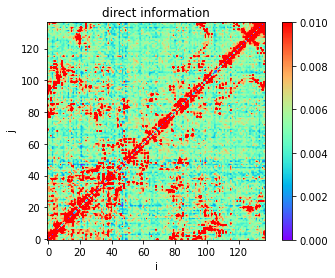

In [15]:
plt.title('direct information')
plt.imshow(ER_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

(137, 137)
ER auc max: 4.823529411764706 0.9304560634578842

Contact threshold:  4.823529411764706


Text(0, 0.5, 'Precision (PPV)')

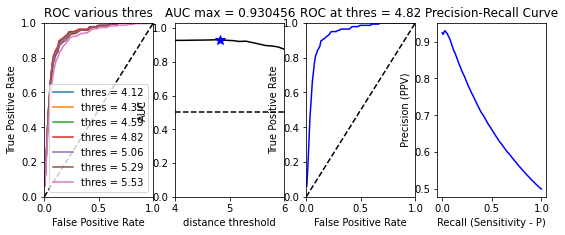

In [16]:
from ecc_tools import roc_curve
# find optimal threshold of distance
ct_thres = np.linspace(4.,6.,18,endpoint=True)
n = ct_thres.shape[0]


print(ct.shape)
# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
auc_ER = np.zeros(n)
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_ER[i] = 0

# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct_mat,ER_di,ct_thres[i0_ER])

# ROC-curve tile settings
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


# Plot ROC, AUC and Precision for best ER contact prediction
# AUC
plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'k-')
plt.plot(ct_thres[i0_ER],auc_ER[i0_ER], 'b*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_ER.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
# ROC
plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Precision-Recall
plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
print('\nContact threshold: ', ct_thres[i0_ER])
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER), 'b-', label='thres = %s'%ct_thres[i0_ER])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')



### Plot DCA 

In [17]:
from inference_dca import direct_info_dca
print(s0.shape)
seq_wt_file = None
seq_wt_file = '%s/protein_data/data_processing_output/seq_weight_%s.npy' % (DCA_ER_dir, pfam_id)

# ----------- DCA DI (MF) calculation --------------------------------------------- #

mf_di, fi, fij, c, cinv, w, w2d, fi_pydca, fij_pydca, c_pydca, c_inv_pydca, w_pydca, w2d_pydcak, di_pydca  = direct_info_dca(s0, seq_wt_outfile=seq_wt_file)
print('c[0]:',c[0])
print('c_pydca[0]', c_pydca[0])

(6573, 160)
(6573, 160)
(160, 21)
meff for our MF =  2361.2850815700986
(160, 21)
(160, 21)
(12720, 20, 20)
3200
c[0]: [ 0.02324263 -0.00056689 -0.00056689 ...  0.00056689  0.00056689
  0.00056689]
c_pydca[0] [ 0.02324263 -0.00056689 -0.00056689 ...  0.00056689  0.00056689
 -0.01133513]


(137, 137)
(137, 137)
cinv[0] [82.85617445 40.85617445 40.85617445 ... -1.14382555 -1.14382555
 -1.14382555]


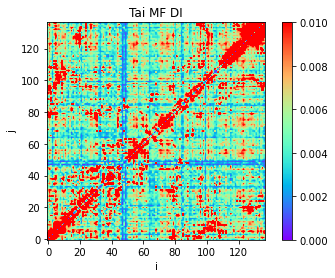

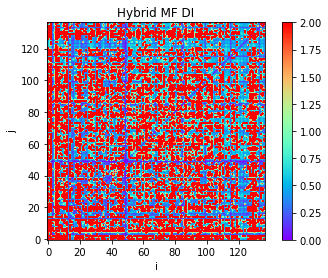

In [18]:
MF_di = np.delete(mf_di, cols_removed,0)
MF_di = np.delete(MF_di, cols_removed,1)
MF_hybrid_di = np.delete(di_pydca, cols_removed,0)
MF_hybrid_di = np.delete(MF_hybrid_di, cols_removed,1)
# --------------------------------------------------------------------------------- #
print(MF_di.shape)
plt.title('Tai MF DI')
plt.imshow(MF_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0.,.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.figure()
print(MF_hybrid_di.shape)
plt.title('Hybrid MF DI')
plt.imshow(MF_hybrid_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(2.,0.)
plt.colorbar(fraction=0.045, pad=0.05)
print('cinv[0]', cinv[0])

auc max: 4.823529411764706 0.8897493075152073


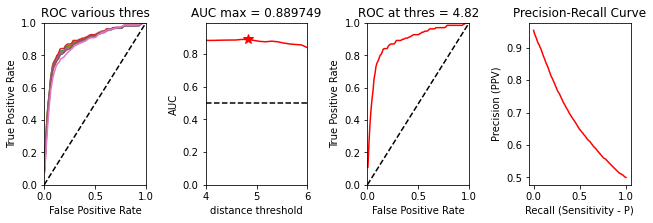

In [19]:
# Run our version of MF di scores through Average Product Correction (to combat influences of phylogeny)
# mf_APC = score_APC(MF_di, sequence_length, s_index)
# MF_di = tools.di_dict2mat(mf_APC, cols_removed, s_index)

# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# find optimal threshold of distance
auc_MF = np.zeros(n)

for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, MF_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        
i0_MF = np.argmax(auc_MF)
print('auc max:',ct_thres[i0_MF],auc_MF[i0_MF])
p0_MF,tp0_MF,fp0_MF = tools.roc_curve(ct,MF_di,ct_thres[i0_MF])


plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_MF[i0_MF]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_MF,'r-')
plt.plot(ct_thres[i0_MF],auc_MF[i0_MF], 'r*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_MF.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_MF]))
plt.plot(fp0_MF,tp0_MF,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
plt.plot(p0_MF, tp0_MF / (tp0_MF + fp0_MF), 'r-', label='thres = %s'%ct_thres[i0_MF])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)

In [20]:
def slice_couplings(couplings = None, site_pair = None, num_site_states=None):
    """Returns couplings corresponding to site pair (i, j). Note that the
    the couplings involving gaps are included, but they are set to zero.

    Parameters
    ----------
        couplings : np.array
            A 2d numpy array of couplings. It has a shape of (L(q-1), L(q-1))
            where L and q are the length of sequences in alignment data and total
            number of standard residues plus gap.
        site_pair : tuple
            A tuple of site pairs. Example (0, 1), (0, L-1), ..., (L-2, L-1).
        num_site_states : int
            The value of q.

    Returns
    -------
        couplings_ij : np.array
            A2d numpy array of shape (q, q) containing the couplings. Note that
            couplings_ij[q, :] and couplings[:, q] are set to zero.
    """
    q = num_site_states
    couplings_ij = np.zeros((q, q), dtype = np.float64)
    row_begin = site_pair[0] * (q - 1)
    row_end = row_begin + q - 1
    column_begin = site_pair[1] * (q -1)
    column_end = column_begin + q - 1
    couplings_ij[:q-1, :q-1] = couplings[row_begin:row_end, column_begin:column_end]
    return couplings_ij

# -------------------- Load PYDCA Data ------------------------------------------------------------------- #
DCA_ER_dir = '/home/ecresswell/DCA_ER/'
DCA_ER_dir = '/home/evan/PycharmProjects/DCA_ER/'

out_dir = '%sprotein_data/di/' % DCA_ER_dir
method = "DI"
# Load pydca score pseudo-dictionaries and generate di matrices from them..
mf_score_file = '%s%s_%s_pydca_mf_preproc.npy' % (out_dir, pfam_id, method)
plm_score_file = '%s%s_%s_pydca_plm_preproc.npy' % (out_dir, pfam_id, method)

# list of di scores length of: seq_len choose 2 
# (ie for PF00186 with sequence length 160, this should be length 160 choose 2 = 12720)
mf_scores = np.load(mf_score_file, allow_pickle=True)
plm_scores = np.load(plm_score_file, allow_pickle=True)

# Load pydca data for comparison
reg_fij = np.load('%s%s_pydca_fij_preproc.npy' % (out_dir, pfam_id))
reg_fi = np.load('%s%s_pydca_fi_preproc.npy' % (out_dir, pfam_id))
corr_mat = np.load('%s%s_pydca_corr_preproc.npy' % (out_dir, pfam_id))                                                                             
couplings = np.load('%s%s_pydca_couplings_preproc.npy' % (out_dir, pfam_id))        
fields_ij = np.load('%s%s_pydca_fields_preproc.npy' % (out_dir, pfam_id))

# print(corr_mat[1][:20])
# print(c[1][:20])
# print(corr_mat.shape)
# print(c.shape)
# -------------------------------------------------------------------------------------------------------- #
# plot difference between coupling matrices (PYDCA MF and our MF)

from inference_dca import interactions, direct_info, mapkey
l = s0.shape[1] # l --> number of aa in each sequence
print('aa sequence length l = %d' % l)

q = 21


print(couplings.shape) # 160 pos x 20 aa
print(w2d.shape) # 137 pos x 21 aa
print(cinv.shape)
print(c.shape)
print(w[0][5][0])
print(w.shape)

w_2D = np.zeros(couplings.shape)
w_vals = []
for i in range(l):
    for j in range(i, l):
        for alpha in range(q-1):
            row = mapkey(i,alpha,q)
            for beta in range(q-1):
                col=mapkey(j,beta,q)
                try:
                    w_2D[row, col] = w[i][j][alpha][beta]
                    w_2D[col, row] = w[i][j][alpha][beta]
                    w_vals.append(couplings[row,col])
                except(IndexError):
                    print(i, j, alpha, beta)
                    print(w_2D)
print('min value in w: ', min(w_vals))
print('max value in w: ', max(w_vals))

aa sequence length l = 160
(3200, 3200)
(3360, 3360)
(3200, 3200)
(3200, 3200)
[-0.06691454  0.1488392   0.1488392   0.1488392   0.04465262  0.1488392
  0.1488392   0.1488392   0.1488392   0.04768245  0.1488392   0.1488392
  0.1488392   0.1488392   0.1488392   0.11297458  0.1488392  -0.08140288
 -0.07227261  0.12124922  0.        ]
(160, 160, 21, 21)
min value in w:  -84.00000000000706
max value in w:  10.400939058132712


## Compare Optimal MF and ER
* Taking the optimal threshold for each gives comparable accuracy
* ER Has higher accuracy

DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)
DI shape (full size) (160, 160)
DI shape (scores removed) (137, 137) 
(should be same as ER di shape..)

 (137, 137)
(137, 137)
159


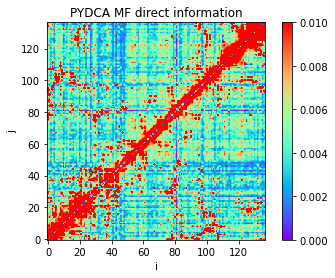

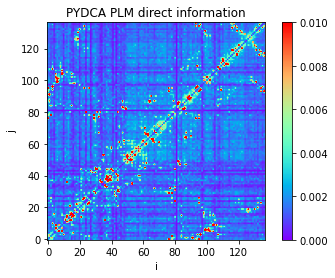

In [21]:


# print(reg_fi.shape)
# print(np.delete(reg_fi, cols_removed, axis=0))
# print(np.delete(reg_fi, cols_removed, axis=0).shape)
# print(fi)
# print(fi.shape)

# print(len(mf_fn_apc))
# print(MF_di.shape)
# print(mf_fn_apc[:5])
pydca_MF_di = tools.di_dict2mat(mf_scores, s_index, cols_removed=cols_removed)
pydca_PLM_di = tools.di_dict2mat(plm_scores, s_index, cols_removed=cols_removed)

# PYDCA_MF_di = np.delete(pydca_MF_di, cols_removed,0)
# PYDCA_MF_di = np.delete(PYDCA_MF_di, cols_removed,1)

# PYDCA_PLM_di = np.delete(pydca_PLM_di, cols_removed,0)
# PYDCA_PLM_di = np.delete(PYDCA_PLM_di, cols_removed,1)

print('\n',pydca_PLM_di.shape)
print(pydca_MF_di.shape)

print(max(s_index))

plt.title('PYDCA MF direct information')
plt.imshow(pydca_MF_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0.,.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.figure()
plt.title('PYDCA PLM direct information')
plt.imshow(pydca_PLM_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0.,.01)
plt.colorbar(fraction=0.045, pad=0.05)

In [22]:
non_triv_cinv = np.nonzero(cinv)
print(non_triv_cinv)
non_triv_c = np.nonzero(c)
print(non_triv_c)
eig_vals, eig_vecs = np.linalg.eig(c)
hybrid_eig_vals, hybrid_eig_vecs = np.linalg.eig(c_pydca)
pydca_eig_vals, pydca_eig_vegs = np.linalg.eig(corr_mat)
eig_diff = [abs(eig_vals[i] - pydca_eig_vals[i]) for i in range(len(eig_vals))]
print('max, mean, std dev eig diff: ', max(eig_diff), np.mean(eig_diff), np.std(eig_diff))
count = 0
for diff in eig_diff:
    if diff > .001:
        count = count + 1
print('%d eigenvalues with diff greater than .001' % count)
print('Tais min eig: ', min(eig_vals))
print('Hybrid min eig: ', min(hybrid_eig_vals))
print('PYDCAs min eig: ', min(pydca_eig_vals))

(array([   0,    0,    0, ..., 3199, 3199, 3199]), array([   0,    1,    2, ..., 3197, 3198, 3199]))
(array([   0,    0,    0, ..., 3199, 3199, 3199]), array([   0,    1,    2, ..., 3197, 3198, 3199]))
max, mean, std dev eig diff:  0.04923304339377327 0.0022579982200325484 0.0074179665808345166
645 eigenvalues with diff greater than .001
Tais min eig:  (0.0011337868480668348+0j)
Hybrid min eig:  (-18.51947205492666+0j)
PYDCAs min eig:  (0.0011337868480680155+0j)


3200


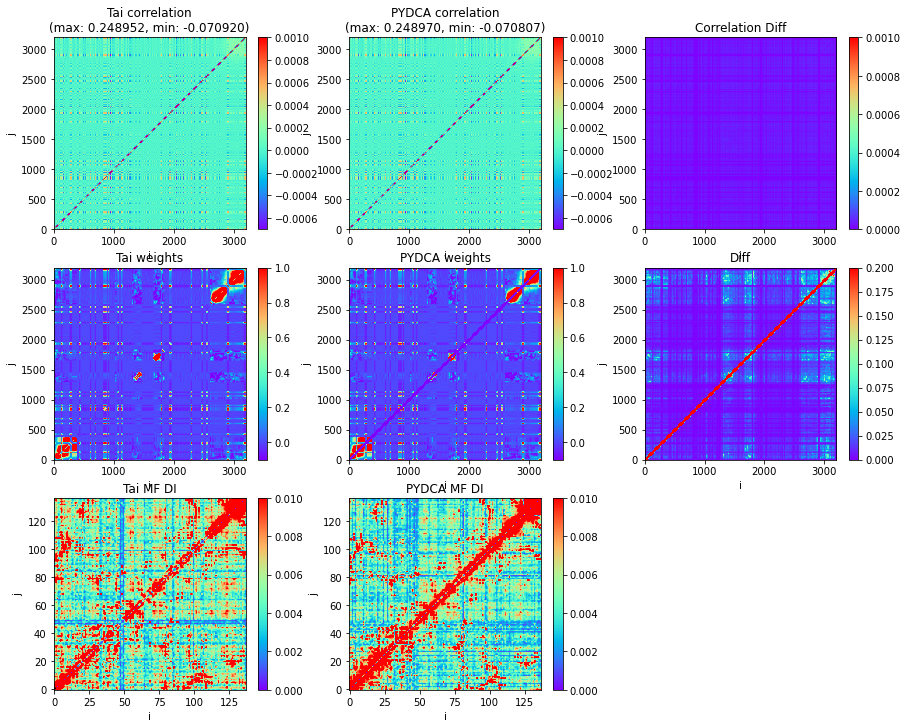

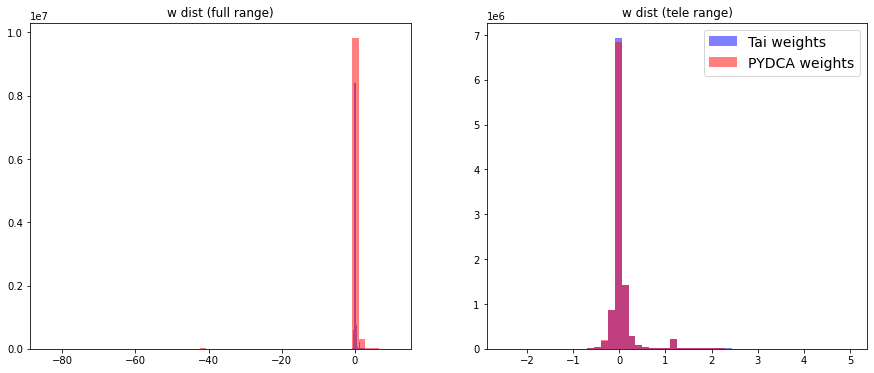

In [23]:
print (len(eig_diff))
plt.figure(figsize=(15.0,12))

# Compare Correlations
plt.subplot2grid((3,3),(0,0))

plt.plot([0,1],[0,1],'k--')
plt.title('Tai correlation\n(max: %f, min: %f)' % (np.amax(c), np.amin(c)))
plt.imshow(c,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(-.0007,.001)
plt.colorbar(fraction=0.045, pad=0.05)

plt.subplot2grid((3,3),(0,1))
plt.title('PYDCA correlation\n(max: %f, min: %f)' % (np.amax(corr_mat), np.amin(corr_mat)))
plt.imshow(corr_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(-.0007,.001)
plt.colorbar(fraction=0.045, pad=0.05)   

plt.subplot2grid((3,3),(0,2))
plt.title('Correlation Diff')
plt.imshow(abs(corr_mat - c),cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,.001)
plt.colorbar(fraction=0.045, pad=0.05)


# Compare Weights
plt.subplot2grid((3,3),(1,0))

plt.plot([0,1],[0,1],'k--')
plt.title('Tai weights')
plt.imshow(w_2D,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(-.1,1.)
plt.colorbar(fraction=0.045, pad=0.05)

plt.subplot2grid((3,3),(1,1))
plt.title('PYDCA weights')
plt.imshow(couplings,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(-.1,1.)
plt.colorbar(fraction=0.045, pad=0.05)   

plt.subplot2grid((3,3),(1,2))
plt.title('Diff')
plt.imshow(abs(couplings - w_2D),cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,.2)
plt.colorbar(fraction=0.045, pad=0.05)


# Compare DIs 
plt.subplot2grid((3,3),(2,0))

plt.plot([0,1],[0,1],'k--')
plt.title('Tai MF DI')
plt.imshow(MF_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0.,.01)
plt.colorbar(fraction=0.045, pad=0.05)

plt.subplot2grid((3,3),(2,1))
plt.title('PYDCA MF DI')
plt.imshow(pydca_MF_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,.01)
plt.colorbar(fraction=0.045, pad=0.05)   
plt.savefig('taiVSpydca_colorplot.pdf')

# ----- PYDCA calculate 'fields' ----- #

# ------------------------------------ #

# # -------------------------- PYDCA's direct info computation --------------------------------------- #
num_unique_pairs = l * (l -1)                                                      
num_unique_pairs /= 2                                                                            
two_site_model_fields = np.zeros((np.int64(num_unique_pairs), 2, q), dtype=np.float64)           
TOLERANCE = 1.0e-4                                                                            
pair_counter = 0


fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.set_title('w dist (full range)')
ax.hist(w_2D.ravel(), alpha=0.5, bins=50, color= 'b', label='Tai weights')
ax.hist(couplings.ravel(), alpha=0.5, bins=50,  color= 'r', label='PYDCA weights')
ax = fig.add_subplot(122)
ax.set_title('w dist (tele range)')
ax.hist(w_2D.ravel(), alpha=0.5,range=(-2.5,5), bins=50, color= 'b', label='Tai weights')
ax.hist(couplings.ravel(), alpha=0.5, bins=50, range=(-2.5,5),  color= 'r', label='PYDCA weights')
ax.legend(loc='upper right', prop={'size':14})
plt.savefig('w_val_distribution.pdf')
# print('MF_di[0]:', MF_di[0, :10])
# print('hybrid_di[0]:', hybrid_di[0, :10])

auc max: 4.470588235294118 0.9579229516428157
auc max: 4.470588235294118 0.8943131590494326


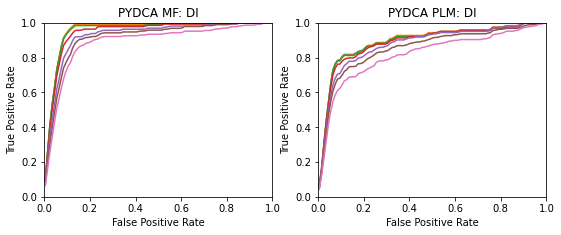

In [24]:
# ER_di = np.delete(di, cols_removed,0)
# ER_di = np.delete(ER_di, cols_removed,1)
# Get best auc for PYDCA mf and plm (and plot the ROC curves)

# which contact matrix do you want to use (full or curated)
ct_mat = ct_full # full pdb contact matrix without columns removed
ct_mat = ct  # full pdb contact matrix with conserved and bad columns removed (defined during pre-processing)
plt.figure(figsize=(9.0,3.2))

plt.title('ROC for PYDCA scores')

# PYDCA-MF
auc_pydca_MF = np.zeros(n)

ax1 = plt.subplot2grid((1,2),(0,0))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_MF_di, ct_thres[i])
        if i in iplot:
            ax1.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('PYDCA MF: %s' % method)
        
i0_pydca_MF = np.argmax(auc_pydca_MF)
print('auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
p0_pydca_MF,tp0_pydca_MF,fp0_pydca_MF = tools.roc_curve(ct_mat,pydca_MF_di,ct_thres[i0_pydca_MF])


# PYDCA-PLM
auc_pydca_PLM = np.zeros(n)

ax2 = plt.subplot2grid((1,2),(0,1))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_PLM_di, ct_thres[i])
        if i in iplot:
            ax2.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_PLM[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_pydca_PLM[i] = 0
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('PYDCA PLM: %s' %method)
        
i0_pydca_PLM = np.argmax(auc_pydca_PLM)
print('auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])
p0_pydca_PLM,tp0_pydca_PLM,fp0_pydca_PLM = tools.roc_curve(ct_mat,pydca_PLM_di,ct_thres[i0_pydca_PLM])

In [25]:
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
print('DCA auc max:',ct_thres[i0_MF],auc_MF[i0_MF])

print('PYDCA MF auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
print('PYDCA PLM auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])

ER auc max: 4.823529411764706 0.9304560634578842
DCA auc max: 4.823529411764706 0.8897493075152073
PYDCA MF auc max: 4.470588235294118 0.9579229516428157
PYDCA PLM auc max: 4.470588235294118 0.8943131590494326


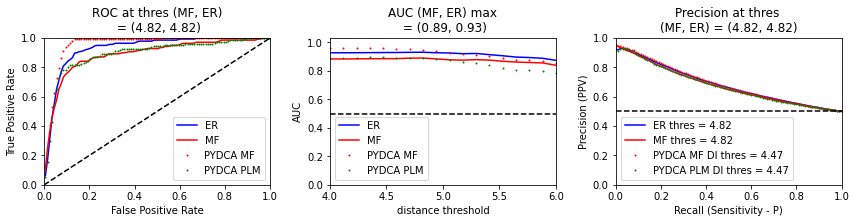

In [26]:
plt.figure(figsize=(12.0,3.2))

# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (MF, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
plt.plot(fp0_MF,tp0_MF,'r-',label="MF")
plt.plot(fp0_pydca_MF,tp0_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(fp0_pydca_PLM,tp0_pydca_PLM,'go',label="PYDCA PLM", markersize=1)

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (MF, ER) max\n = (%3.2f, %3.2f)' %(auc_MF[i0_MF], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'b-',label="ER")
plt.plot(ct_thres,auc_MF,'r-',label="MF")
plt.plot(ct_thres,auc_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(ct_thres,auc_pydca_PLM,'go',label="PYDCA PLM", markersize=1)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,max(auc_MF.max(), auc_ER.max())+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(MF, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER thres = %3.2f'%ct_thres[i0_ER])
plt.plot( p0_MF,tp0_MF / (tp0_MF + fp0_MF),'r-',label='MF thres = %3.2f'%ct_thres[i0_MF])
plt.plot( p0_pydca_MF,tp0_pydca_MF / (tp0_pydca_MF + fp0_pydca_MF),'ro',label='PYDCA MF %s thres = %3.2f' % (method, ct_thres[i0_pydca_MF]), markersize=1)
plt.plot( p0_pydca_PLM,tp0_pydca_PLM / (tp0_pydca_PLM + fp0_pydca_PLM),'go',label='PYDCA PLM %s thres = %3.2f' % (method, ct_thres[i0_pydca_PLM]), markersize=1)

plt.plot([0,1.],[.5,.5],'k--')
plt.xlim([0,1])
plt.ylim([0,1]) 
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)

plt.savefig('ERvPYDCA_%s_comparison.pdf' % method)


# tools.hide_toggle()